In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from numpy import sqrt, pi, exp, transpose, matmul
from sklearn.model_selection import KFold, train_test_split
from scipy import stats

# import custom mnist and svm modules
import mnist
from svm import *

**Data prep**

In [2]:
# load MNIST
mnist.init()
x_train, y_train, x_test, y_test = mnist.load()
x_train_scaled = x_train / 255

In [3]:
# create custom data set: 500 train and 200 test per label
# all data scaled [0,1]
np.random.seed(0)
data = np.hstack((y_train.reshape(-1,1),x_train_scaled))
data_1 = data[data[:,0]==1]
data_2 = data[data[:,0]==9]
data_3 = data[data[:,0]==6]

np.random.shuffle(data_1)
np.random.shuffle(data_2)
np.random.shuffle(data_3)

train = np.vstack((data_1[:500], data_2[:500], data_3[:500]))
test = np.vstack((data_1[500:700], data_2[500:700], data_3[500:700]))
np.random.shuffle(train)
np.random.shuffle(test)

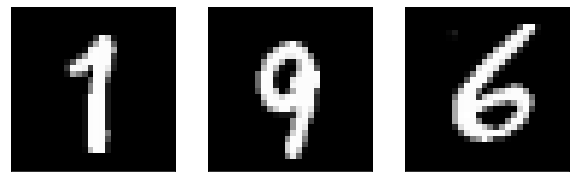

In [4]:
# plot example digits
fig, axs = plt.subplots(1, 3, figsize = (10,7))
d_sets = [data_1[4,1:], data_2[19,1:], data_3[3,1:]]
for digit, ax in enumerate(axs.flat):
    ax.imshow(np.reshape(d_sets[digit],(28, 28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

**OvO classification function**

In [5]:
def ovo_classify(C, kernel, kernel_param, optimiser, seed=True):
    "OvO classification test"

    # OvO digit combinations
    digits = np.array([[1,6],[1,9],[6,9]])

    x_train = train[:,1:]
    y_train = train[:,0]
    x_test = test[:,1:]
    y_test = test[:,0]

    # convert y_train to binary matrix
    # each row contains the binary labels for a different OvO classifier
    y_train_matrix = np.vstack([y_train]*3)
    y_train_binary_pre = np.where(y_train_matrix == digits[:,0][:,None], 1, 0)
    y_train_binary = np.where(y_train_matrix == digits[:,1][:,None], -1, y_train_binary_pre)

    I = len(x_train)
    I_test = len(x_test)

    # prediction arrays before aggregation
    y_train_pred = np.zeros((3,I))
    y_test_pred = np.zeros((3,I_test))
    info_list = []
    times = np.zeros(3)
    
    for i in range(3):

        # training data for SVM
        x_ovo = x_train[y_train_binary[i] != 0]
        y_ovo = y_train_binary[i][y_train_binary[i] != 0]

        # fit and predict
        svm = SVM(C, kernel, kernel_param, optimiser, seed=seed)
        
        start_time = time.time()
        info = svm.fit(x_ovo, y_ovo)
        end_time = time.time()
        times[i] = end_time - start_time
        
        info_list.append(info)
        
        y_train_pred[i] = svm.predict(x_train)
        y_test_pred[i] = svm.predict(x_test)

    # aggregate ovo predictions and compute errors - TRAIN
    votes = np.where(y_train_pred == 1, digits[:,0][:,None], digits[:,1][:,None]).T
    k_pred = np.squeeze(stats.mode(votes, axis=1).mode)
    train_acc = (np.sum(k_pred == y_train)/I)

    # aggregate ovo predictions and compute errors - TEST
    votes = np.where(y_test_pred == 1, digits[:,0][:,None], digits[:,1][:,None]).T
    k_pred = np.squeeze(stats.mode(votes, axis=1).mode)
    test_acc = (np.sum(k_pred == y_test)/I_test)

    # store final errors
    #print('train acc: %.3f' % train_acc)
    #print('test acc: %.3f' % test_acc)
    #print('fit time av: %.3f' % np.mean(times))
    
    return train_acc, test_acc, info_list


**Classification accuracy**

In [8]:
# barrier
print('----------BARRIER----------')
ovo_classify(1, 'rbf', 0.1, 'barrier')
ovo_classify(1, 'poly', 3, 'barrier')
# smo
print('----------SMO----------')
ovo_classify(1, 'rbf', 0.01, 'smo')
ovo_classify(1, 'poly', 2, 'smo')
# cvxopt
print('----------CVXOPT----------')
ovo_classify(1, 'rbf', 0.01, 'cvxopt')
ovo_classify(1, 'poly', 2, 'cvxopt');

----------BARRIER----------
train acc: 0.998
test acc: 0.970
fit time av: 10.898
train acc: 0.950
test acc: 0.953
fit time av: 11.394
----------SMO----------
train acc: 0.996
test acc: 0.995
fit time av: 5.833
train acc: 1.000
test acc: 0.993
fit time av: 2.602
----------CVXOPT----------
train acc: 0.996
test acc: 0.995
fit time av: 0.485
train acc: 1.000
test acc: 0.993
fit time av: 0.580


In [11]:
# demonstration of overfitting
number_of_points = 30
gammas = np.logspace(-4,-0.5,number_of_points)
overfitting = np.zeros((2,number_of_points))
for g, gamma in enumerate(gammas):
    train_acc, test_acc, _ = ovo_classify(1, 'rbf', gamma, 'smo')
    overfitting[0,g] = train_acc
    overfitting[1,g] = test_acc

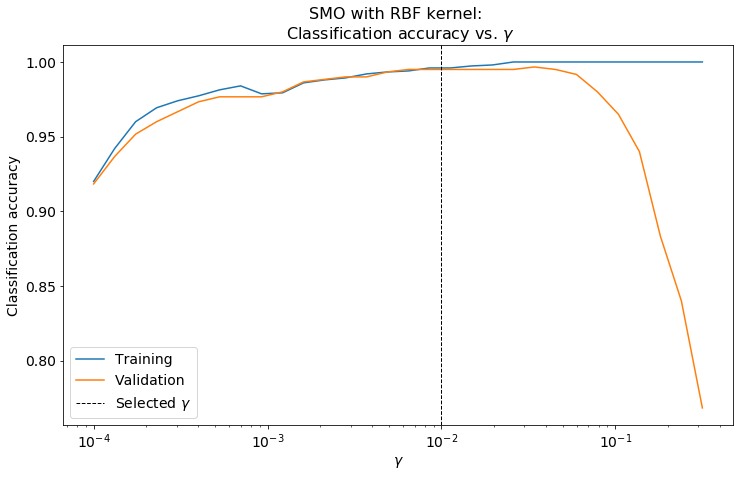

In [12]:
plt.figure(figsize=(12,7))
plt.xscale('log')
plt.plot(np.logspace(-4,-0.5,number_of_points),overfitting.T)
plt.axvline(10**(-2), color = 'black', linestyle='--', linewidth=1)
plt.xlabel('$\gamma$', size = 14)
plt.ylabel('Classification accuracy', size = 14)
plt.title('SMO with RBF kernel: \n Classification accuracy vs. $\gamma$', size = 16)
plt.legend(['Training', 'Validation', 'Selected $\gamma$'],loc="lower left", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

**Barrier convergence (iterates)**

In [ ]:
# RBF kernel, outer iterates
train_acc, test_acc, info_list = ovo_classify(1, 'rbf', 0.1, 'barrier')

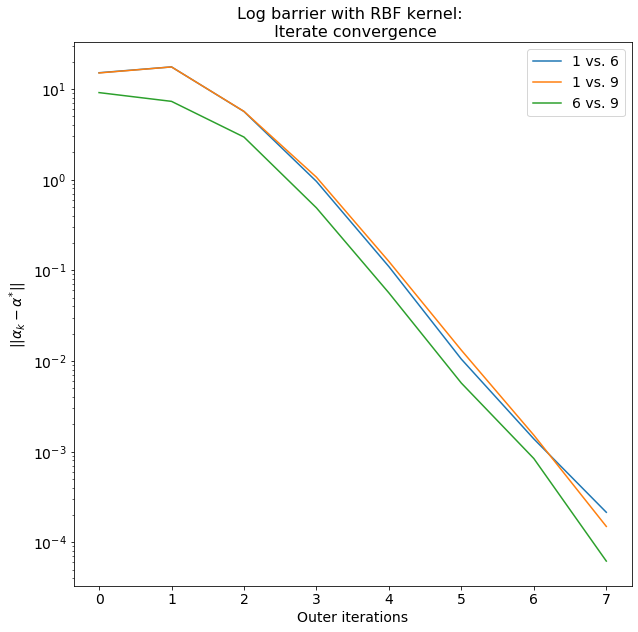

In [8]:
# plot convergence
iterate_norms = []
for i in range(3):
    x_star = np.squeeze(info_list[i]['iterates'])[-1]
    x_remaining = np.squeeze(info_list[i]['iterates'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms.append([np.linalg.norm(iterate) for iterate in x_diff])
iterate_norms = np.array(iterate_norms)


plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(iterate_norms.T)
plt.xlabel('Outer iterations', size = 14)
plt.ylabel('$||α_{k}-α^{*}||$', size = 14)
plt.title('Log barrier with RBF kernel: \n Iterate convergence', size = 16)
plt.legend(['1 vs. 6', '1 vs. 9', '6 vs. 9'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [ ]:
# polynomial kernel, outer iterates
train_acc, test_acc, info_list = ovo_classify(1, 'poly', 3, 'barrier')

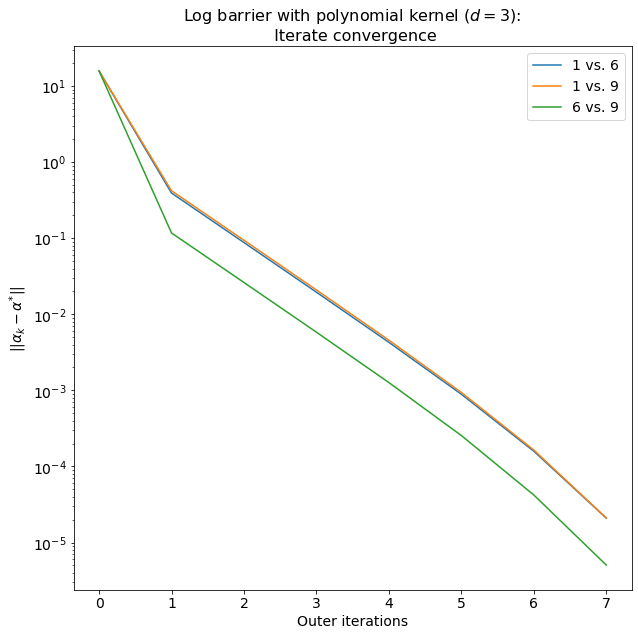

In [10]:
# plot convergence
iterate_norms = []
for i in range(3):
    x_star = np.squeeze(info_list[i]['iterates'])[-1]
    x_remaining = np.squeeze(info_list[i]['iterates'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms.append([np.linalg.norm(iterate) for iterate in x_diff])
iterate_norms = np.array(iterate_norms)

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(iterate_norms.T)
plt.xlabel('Outer iterations', size = 14)
plt.ylabel('$||α_{k}-α^{*}||$', size = 14)
plt.title('Log barrier with polynomial kernel ($d=3$): \n Iterate convergence', size = 16)
plt.legend(['1 vs. 6', '1 vs. 9', '6 vs. 9'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

**Barrier convergence (duality gap)**

In [17]:
# prepare 1 vs 6 dataset
train_1 = train[train[:,0]==1]
train_6 = train[train[:,0]==6]
train_6[:,0]=np.ones(len(train_6))*-1
train_16 = np.vstack([train_1, train_6])
np.random.seed(0)
np.random.shuffle(train_16)
train_16_X = train_16[:,1:]
train_16_y = train_16[:,0]

In [ ]:
# RBF kernel: cycle mus
mu_steps = []
for mu in [1.5,5, 20, 200]:
    svm = SVM(1, 'rbf', 0.1, 'barrier', mu)
    info = svm.fit(train_16_X, train_16_y)
    mu_steps.append(info['duality_gaps'])

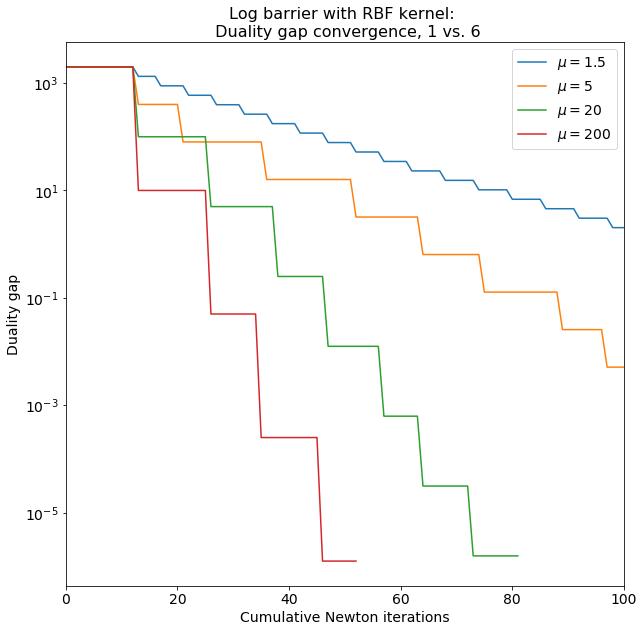

In [20]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(mu_steps[0])
plt.plot(mu_steps[1])
plt.plot(mu_steps[2])
plt.plot(mu_steps[3])

plt.xlim([0,100])
plt.xlabel('Cumulative Newton iterations', size = 14)
plt.ylabel('Duality gap', size = 14)
plt.title('Log barrier with RBF kernel: \n Duality gap convergence, 1 vs. 6', size = 16)
plt.legend(['$\mu=1.5$', '$\mu=5$', '$\mu=20$', '$\mu=200$'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


In [ ]:
# Poly kernel: cycle mus
mu_steps = []
for mu in [1.5,5, 20, 200]:
    svm = SVM(1, 'poly', 3, 'barrier', mu)
    info = svm.fit(train_16_X, train_16_y)
    mu_steps.append(info['duality_gaps'])

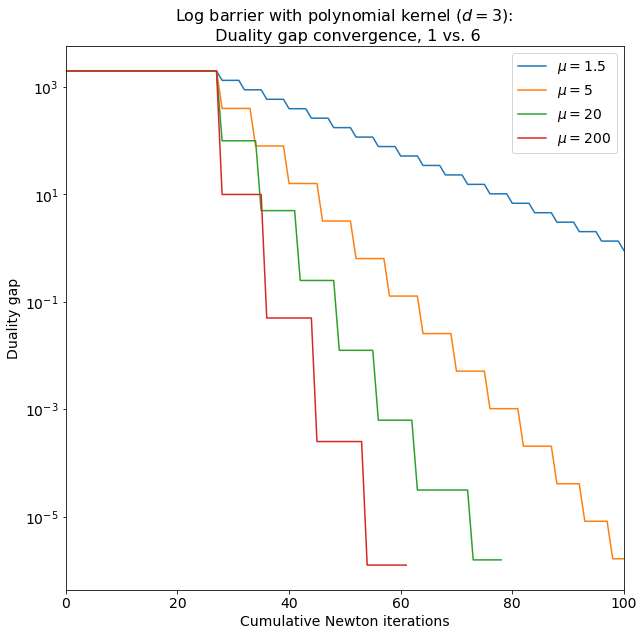

In [22]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(mu_steps[0])
plt.plot(mu_steps[1])
plt.plot(mu_steps[2])
plt.plot(mu_steps[3])

plt.xlim([0,100])
plt.xlabel('Cumulative Newton iterations', size = 14)
plt.ylabel('Duality gap', size = 14)
plt.title('Log barrier with polynomial kernel ($d=3$): \n Duality gap convergence, 1 vs. 6', size = 16)
plt.legend(['$\mu=1.5$', '$\mu=5$', '$\mu=20$', '$\mu=200$'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()



**SMO convergence (iterates)**

In [11]:
# RBF kernel
train_acc, test_acc, info_list = ovo_classify(1, 'rbf', 0.01, 'smo')

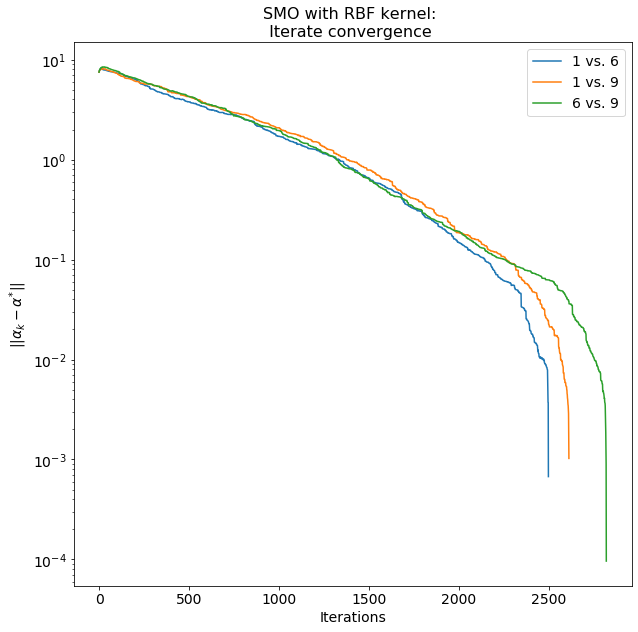

In [12]:
# plot convergence
iterate_norms = []
for i in range(3):
    x_star = np.squeeze(info_list[i]['iterates'])[-1]
    x_remaining = np.squeeze(info_list[i]['iterates'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms.append([np.linalg.norm(iterate) for iterate in x_diff])
iterate_norms = np.array(iterate_norms)

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(iterate_norms[0])
plt.plot(iterate_norms[1])
plt.plot(iterate_norms[2])
plt.xlabel('Iterations', size = 14)
plt.ylabel('$||α_{k}-α^{*}||$', size = 14)
plt.title('SMO with RBF kernel: \n Iterate convergence  ', size = 16)
plt.legend(['1 vs. 6', '1 vs. 9', '6 vs. 9'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


In [13]:
# Polynomial kernel
train_acc, test_acc, info_list = ovo_classify(1, 'poly', 2, 'smo')

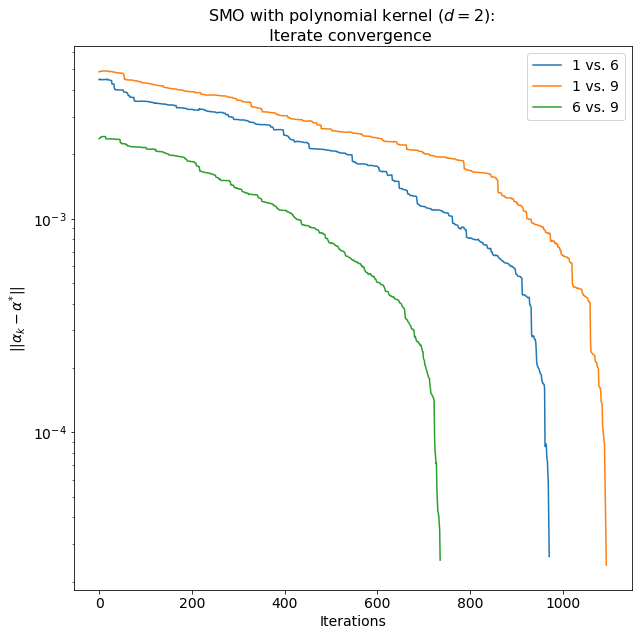

In [14]:
# plot convergence
iterate_norms = []
for i in range(3):
    x_star = np.squeeze(info_list[i]['iterates'])[-1]
    x_remaining = np.squeeze(info_list[i]['iterates'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms.append([np.linalg.norm(iterate) for iterate in x_diff])
iterate_norms = np.array(iterate_norms)

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(iterate_norms[0])
plt.plot(iterate_norms[1])
plt.plot(iterate_norms[2])
plt.xlabel('Iterations', size = 14)
plt.ylabel('$||α_{k}-α^{*}||$', size = 14)
plt.title('SMO with polynomial kernel ($d=2$): \n Iterate convergence  ', size = 16)
plt.legend(['1 vs. 6', '1 vs. 9', '6 vs. 9'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


**SMO convergence: alpha updates per loop**

In [14]:
# RBF kernel

# deterministic sample
_, _, info_list = ovo_classify(1, 'rbf', 0.01, 'smo')
x_star = np.squeeze(info_list[0]['changes'])[-1]
x_remaining = np.squeeze(info_list[0]['changes'])[:-1]
x_diff = x_remaining - x_star
iterate_norms_single = np.array([np.linalg.norm(iterate) for iterate in x_diff])
    
# stochastic samples
samples = 100
iterate_norms_padded_array = np.zeros((samples,1000))
for i in range(samples):
    _, _, info_list = ovo_classify(1, 'rbf', 0.01, 'smo', seed=False)
    x_star = np.squeeze(info_list[0]['changes'])[-1]
    x_remaining = np.squeeze(info_list[0]['changes'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms = np.array([np.linalg.norm(iterate) for iterate in x_diff])
    iterate_norms_padded = np.hstack([iterate_norms, np.zeros(1000-len(iterate_norms))])
    iterate_norms_padded_array[i]=iterate_norms_padded

iterate_norms_ave = np.mean(iterate_norms_padded_array,0)[:len(iterate_norms_single)]




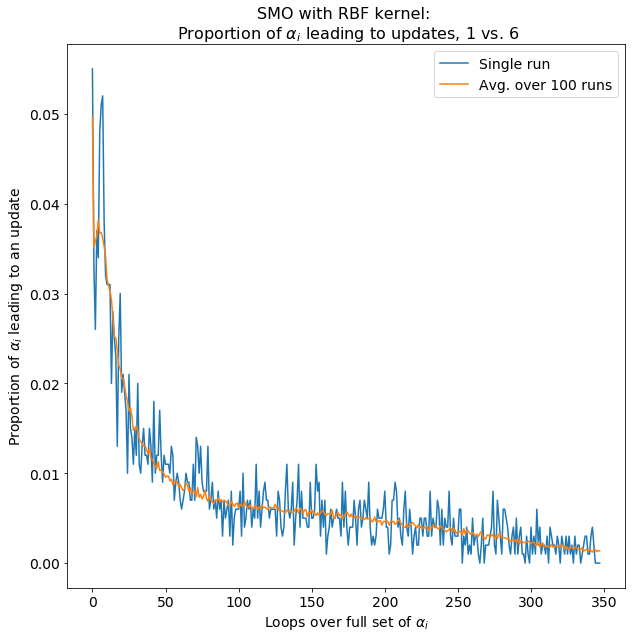

In [21]:
# plot convergence
plt.figure(figsize=(10,10))
#plt.yscale('log')
plt.plot(iterate_norms_single/1000)
plt.plot(iterate_norms_ave/1000)
plt.xlabel('Loops over full set of $α_{i}$', size = 14)
plt.ylabel('Proportion of $α_{i}$ leading to an update', size = 14)
plt.title('SMO with RBF kernel: \n Proportion of $α_{i}$ leading to updates, 1 vs. 6', size = 16)
plt.legend(['Single run', 'Avg. over 100 runs'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


In [22]:
# Polynomial kernel

# deterministic sample
_, _, info_list = ovo_classify(1, 'poly', 2, 'smo')
x_star = np.squeeze(info_list[0]['changes'])[-1]
x_remaining = np.squeeze(info_list[0]['changes'])[:-1]
x_diff = x_remaining - x_star
iterate_norms_single = np.array([np.linalg.norm(iterate) for iterate in x_diff])
    
# stochastic samples
samples = 100
iterate_norms_padded_array = np.zeros((samples,1000))
for i in range(samples):
    _, _, info_list = ovo_classify(1, 'poly', 2, 'smo', seed = False)
    x_star = np.squeeze(info_list[0]['changes'])[-1]
    x_remaining = np.squeeze(info_list[0]['changes'])[:-1]
    x_diff = x_remaining - x_star
    iterate_norms = np.array([np.linalg.norm(iterate) for iterate in x_diff])
    iterate_norms_padded = np.hstack([iterate_norms, np.zeros(1000-len(iterate_norms))])
    iterate_norms_padded_array[i]=iterate_norms_padded

iterate_norms_ave = np.mean(iterate_norms_padded_array,0)[:len(iterate_norms_single)]


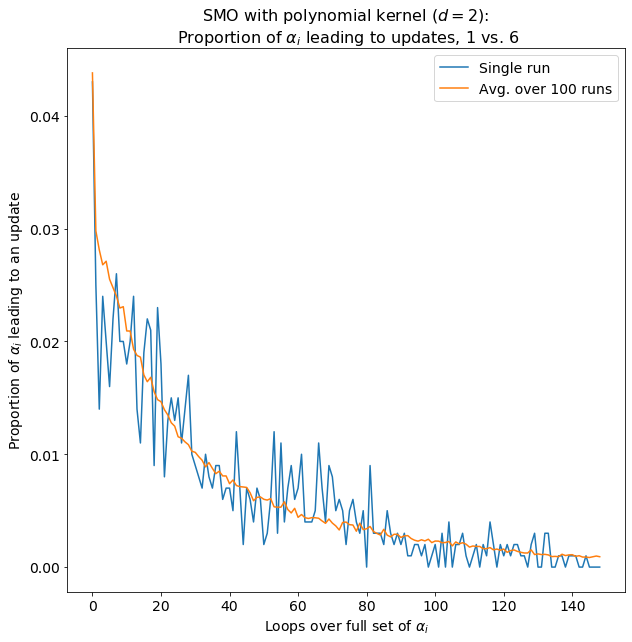

In [24]:
# plot convergence
plt.figure(figsize=(10,10))
#plt.yscale('log')
plt.plot(iterate_norms_single/1000)
plt.plot(iterate_norms_ave/1000)
plt.xlabel('Loops over full set of $α_{i}$', size = 14)
plt.ylabel('Proportion of $α_{i}$ leading to an update', size = 14)
plt.title('SMO with polynomial kernel ($d=2$): \n Proportion of $α_{i}$ leading to updates, 1 vs. 6', size = 16)
plt.legend(['Single run', 'Avg. over 100 runs'],loc="upper right", prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()